In [11]:
import jax


%env JAX_PLATFORM_NAME=cuda

from test.helpers import (
    SDE,
)

import diffrax
import jax.numpy as jnp
import jax.random as jr
from diffrax import (
    ALIGN,
    diffeqsolve,
    LangevinTerm,
    ShARK,
    ShOULD,
    SORT,
)
from drawing_and_evaluating import (
    constant_step_strong_order,  # noqa: F401
    pid_strong_order,  # noqa: F401
    plot_sol_langevin,
    remove_steps,
)
from jax import config


config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_disable_jit", False)
jnp.set_printoptions(precision=4, suppress=True)

dtype = jnp.float64
key = jr.PRNGKey(2)
num_samples = 1000
keys = jr.split(jr.PRNGKey(5678), num=num_samples)
keys_funnel = jr.split(jr.PRNGKey(77), 100)

t0, t1 = 0.0, 16.0
t_short = 4.0
dt0 = 0.1
bm_tol = 2**-16
levy_area = diffrax.SpaceTimeTimeLevyArea

half_should = diffrax.HalfSolver(ShOULD(0.01))
half_sort = diffrax.HalfSolver(SORT(0.01))
half_heun = diffrax.HalfSolver(diffrax.Heun())
half_align = diffrax.HalfSolver(ALIGN(0.1))
half_shark = diffrax.HalfSolver(ShARK())
half_sra1 = diffrax.HalfSolver(diffrax.SRA1())

env: JAX_PLATFORM_NAME=cuda


In [16]:
def f(x):
    return (x - 5) ** 2 * (x + 5) ** 2


grad_f = jax.grad(f)
args = (20.0, 0.1, grad_f)

x0 = 0 * jnp.ones((), jnp.float64)
y0 = (x0, jnp.zeros((), jnp.float64))

w_shape = ()


def get_terms(bm):
    return LangevinTerm(args, bm, x0)


t_long = 10000
x4_sde = SDE(get_terms, None, y0, t0, t_long, w_shape)

bm_key = jr.key(0)
bm = x4_sde.get_bm(bm_key, diffrax.SpaceTimeTimeLevyArea, 2**-8)
x4_terms = x4_sde.get_terms(bm)

dt0 = 0.1
controller = diffrax.PIDController(
    rtol=0,
    atol=0.2,
    pcoeff=0.1,
    icoeff=0.4,
    dcoeff=0,
    dtmin=2**-8,
    dtmax=5.0,
)

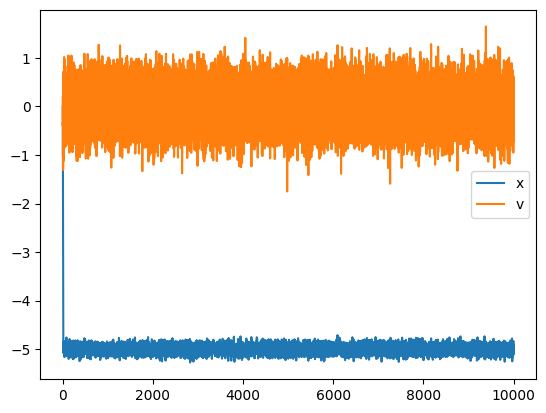

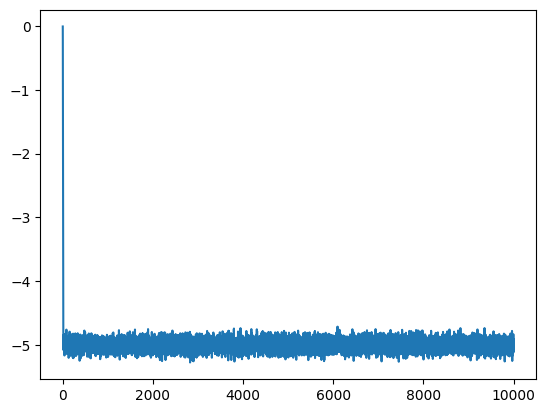

In [17]:
import matplotlib.pyplot as plt


sol = diffeqsolve(
    x4_terms,
    half_sort,
    t0,
    t_long,
    0.1,
    x4_sde.y0,
    None,
    saveat=diffrax.SaveAt(steps=True),
    stepsize_controller=controller,
    max_steps=2**16,
)

plot_sol_langevin(sol)

plt.plot(sol.ts, sol.ys[0])

In [25]:
ord_x4_const = constant_step_strong_order(keys, x4_sde, half_sort, (2, 10))

ord_x4_adap = pid_strong_order(keys, x4_sde, half_sort, (2, 10))

E0604 14:32:38.540959    5630 pjrt_stream_executor_client.cc:2809] Execution of replica 0 failed: RESOURCE_EXHAUSTED: CUDA driver ran out of memory trying to instantiate CUDA graph with 12 nodes and 0 conditionals (total of 0 alive CUDA graphs in the process). You can try to (a) Give more memory to CUDA driver by reducing XLA_PYTHON_CLIENT_MEM_FRACTION (b) Disable CUDA graph with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph:CUDA_ERROR_OUT_OF_MEMORY: out of memory


XlaRuntimeError: RESOURCE_EXHAUSTED: CUDA driver ran out of memory trying to instantiate CUDA graph with 12 nodes and 0 conditionals (total of 0 alive CUDA graphs in the process). You can try to (a) Give more memory to CUDA driver by reducing XLA_PYTHON_CLIENT_MEM_FRACTION (b) Disable CUDA graph with 'XLA_FLAGS=--xla_gpu_enable_command_buffer=' (empty set). Original error: Failed to instantiate CUDA graph:CUDA_ERROR_OUT_OF_MEMORY: out of memory

In [ ]:
ord_x4_const2 = remove_steps(ord_x4_const, 4, 0)

In [ ]:
from drawing_and_evaluating import draw_order_multiple_dict


_ = draw_order_multiple_dict(
    {
        "Constant step": ord_x4_const2,
        "Adaptive step": ord_x4_adap,
    }
)